# Time Series Model

## Context

As discussed in previous notebooks, we will use dynamic harmonic regression model to remove all time dependencies from our series. While an sARIMA model could theoretically capture all patterns at once, our data is daily with a seasonal pattern, making it computationally expensive to train.

**Data Source**
The data used in this notebook was extracted from the notebook *exploratory_analysis/eda-linear.ipynb*

- **Data:** 20/11/2025
- **Localização:** ../data/wrangle

## Set up

### Libraries

In [1]:
## Base
import os
import pickle
import numpy as np
import pandas as pd
from itertools import product

## Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Model
from scipy.stats import iqr, boxcox
from scipy.special import inv_boxcox
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from scipy.stats import iqr

# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Funções criadas
import sys
from pathlib import Path
sys.path.insert(1, Path.cwd().parents[1].as_posix())

from src.ts_utils import *

from config import *

In [3]:
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#003366'])

In [4]:
def fourier(order, period, t):
    comp = pd.DataFrame(index=range(0, t))
    for k in range(1, order+1):
        comp[f'sin_{k}'] = np.sin(2*np.pi*k*comp.index/period)
        comp[f'cos_{k}'] = np.cos(2*np.pi*k*comp.index/period)
        
    return comp

# Data

For this analysis, we will use the training set (5 years) and the validation set (2 years) to determine which models best fit our objective: forecasting 365 steps ahead with the narrowest possible confidence interval. The selected metrics will be Mean Squared Error (MSE).

In [5]:
df = pd.read_parquet(os.path.join(DATA_PATH_WRANGLE, 'weather_sanitized.parquet'))

df_train = df.head(5 * 365).copy()
df_train_valid = df.head(7 * 365).copy()

# Regression Models 
The models were trained using 1, 2, 3, or 4 pairs of harmonic components, as well as testing p = 0, 1, 2, 3; q = 0, 1, 2, 3; d = 0, 1; and the Box–Cox transformation.

To simplify model selection, we will choose the best model using AIC. However, models with different values of d or with the Box–Cox transformation are fundamentally different and therefore cannot be directly compared using AIC.

Because of this, we will first select the best model according to AIC within each group (each fixed d and the Box–Cox variant), and then compare those four resulting models using expanding cross-validation.

In [6]:
candidates = pd.DataFrame(product(range(0, 5), repeat=3), columns=['p', 'q', 'f'])
candidates = candidates.loc[(candidates['f'] >= 1) & ~((candidates['p'] == 0) & (candidates['q'] == 0)) &
                            (candidates['p'] <= 3) & (candidates['q'] <= 3)].reset_index(drop=True)    
candidates.head(3)

,p,q,f
0,0,1,1
1,0,1,2
2,0,1,3


## With d=0

In [7]:
model_aic = []
for r, parameters in tqdm(candidates.iterrows(), total=candidates.shape[0], desc='Candidates'):
    # Data
    p, q, f = parameters
    y = df_train['tavg']
    X = fourier(f, 365, len(y))

    # Model
    model = ARIMA(y, X, order=(p,0,q)).fit()
    model_aic.append([f'ARIMA({p},0,{q})F({f})', model.aic])

Candidates: 100%|█████████████████████████████████████████████████████████████████████████████████| 60/60 [02:03<00:00,  2.06s/it]


In [8]:
cand_d0 = pd.DataFrame(model_aic, columns = ['model', 'AIC']).sort_values('AIC')
cand_d0.head(5)

,model,AIC
36,"ARIMA(2,0,2)F(1)",9485.934160
37,"ARIMA(2,0,2)F(2)",9486.182751
24,"ARIMA(1,0,3)F(1)",9486.769404
25,"ARIMA(1,0,3)F(2)",9486.896925
52,"ARIMA(3,0,2)F(1)",9487.885208


According to the AIC, the ARIMA(2,0,2) model with one Fourier component is the best in this group.

## With d=0 & Box-Cox

In [9]:
model_aic = []
for r, parameters in tqdm(candidates.iterrows(), total=candidates.shape[0], desc='Candidates'):
    # Data
    p, q, f = parameters
    y, _lambd = boxcox(df_train['tavg'])
    X = fourier(f, 365, len(y))

    # Model
    model = ARIMA(y, X, order=(p,0,q)).fit()
    model_aic.append([f'ARIMA({p},0,{q})F({f})', model.aic])

Candidates: 100%|█████████████████████████████████████████████████████████████████████████████████| 60/60 [01:13<00:00,  1.23s/it]


In [10]:
cand_d0B = pd.DataFrame(model_aic, columns = ['model', 'AIC']).sort_values('AIC')
cand_d0B.head(5)

,model,AIC
37,"ARIMA(2,0,2)F(2)",98001.613199
25,"ARIMA(1,0,3)F(2)",98002.393087
36,"ARIMA(2,0,2)F(1)",98002.397880
24,"ARIMA(1,0,3)F(1)",98003.374093
53,"ARIMA(3,0,2)F(2)",98003.578852


According to the AIC, the ARIMA(2,0,2) model with a Box–Cox transformation and two Fourier components is the best in this group.

## With d=1

In [11]:
model_aic = []
for r, parameters in tqdm(candidates.iterrows(), total=candidates.shape[0], desc='Candidates'):
    # Data
    p, q, f = parameters
    y = df_train['tavg']
    X = fourier(f, 365, len(y))

    # Model
    model = ARIMA(y, X, order=(p,1,q)).fit()
    model_aic.append([f'ARIMA({p},1,{q})F({f})', model.aic])

Candidates: 100%|█████████████████████████████████████████████████████████████████████████████████| 60/60 [02:46<00:00,  2.77s/it]


In [12]:
cand_d1 = pd.DataFrame(model_aic, columns = ['model', 'AIC']).sort_values('AIC')
cand_d1.head(5)

,model,AIC
25,"ARIMA(1,1,3)F(2)",9485.896779
24,"ARIMA(1,1,3)F(1)",9486.894488
49,"ARIMA(3,1,1)F(2)",9486.986910
53,"ARIMA(3,1,2)F(2)",9487.627065
48,"ARIMA(3,1,1)F(1)",9487.681986


According to the AIC, the ARIMA(1,1,3) model with two Fourier components is the best in this group.

## With d=1 & Box-Cox

In [13]:
model_aic = []
for r, parameters in tqdm(candidates.iterrows(), total=candidates.shape[0], desc='Candidates'):
    # Data
    p, q, f = parameters
    y, _lambd = boxcox(df_train['tavg'])
    X = fourier(f, 365, len(y))

    # Model
    model = ARIMA(y, X, order=(p,1,q)).fit()
    model_aic.append([f'ARIMA({p},1,{q})F({f})', model.aic])

Candidates: 100%|█████████████████████████████████████████████████████████████████████████████████| 60/60 [01:29<00:00,  1.49s/it]


In [14]:
cand_d1B = pd.DataFrame(model_aic, columns = ['model', 'AIC']).sort_values('AIC')
cand_d1B.head(5)

,model,AIC
25,"ARIMA(1,1,3)F(2)",98006.506205
24,"ARIMA(1,1,3)F(1)",98007.888208
37,"ARIMA(2,1,2)F(2)",98008.241802
53,"ARIMA(3,1,2)F(2)",98008.731435
27,"ARIMA(1,1,3)F(4)",98009.445321


According to the AIC, the ARIMA(1,1,3) model with a Box–Cox transformation and two Fourier components is the best in this group.

# Cross Validation
Now we must compare these four models using expanding cross-validation.

In [15]:
new_candidate = pd.DataFrame({'p': [2, 2, 1, 1],
                              'd': [0, 0, 1, 1],
                              'q': [2, 2, 3, 3],
                              'f': [1, 2, 2, 2],
                              'box-cox': [False, True, False, True]})
new_candidate

,p,d,q,f,box-cox
0,2,0,2,1,False
1,2,0,2,2,True
2,1,1,3,2,False
3,1,1,3,2,True


In [16]:
mae_models = pd.DataFrame()
for r, parameters in new_candidate.iterrows():
    p, d, q, f, b = parameters
    y = df_train_valid['tavg']        
    X = fourier(f, 365, df_train_valid.shape[0])
    
    error_list = []
    for i in tqdm(range(-2*365, -365), desc=f"Candidate {r+1}", position=0, leave=True):
        # Sets
        X_train = X[:i]
        X_valid = X[i:i+365]
        y_valid = y[i:i+365]

        if not b:
            y_train, _lambd = boxcox(y[:i])
        else:
            y_train = y[:i]
            
        # Model
        model = ARIMA(y_train, X_train, order=(p,d,q)).fit()

        if not b:
            forecast_box = model.forecast(365, exog=X_valid)
            forecast = inv_boxcox(forecast_box, _lambd)
            
        else:
            forecast = model.forecast(365, exog=X_valid)

        # Error
        error = abs(forecast - y_valid).reset_index(drop=True)   
        error_list.append(error)

    resid_df = pd.concat(error_list, axis=1, ignore_index=True)
    mae_models[f'ARIMA({p},{d},{q})F({f})B({b})'] = resid_df.mean(axis=1)

Candidate 4: 100%|██████████████████████████████████████████████████████████████████████████████| 365/365 [21:58<00:00,  3.61s/it]


## Visual Analysis

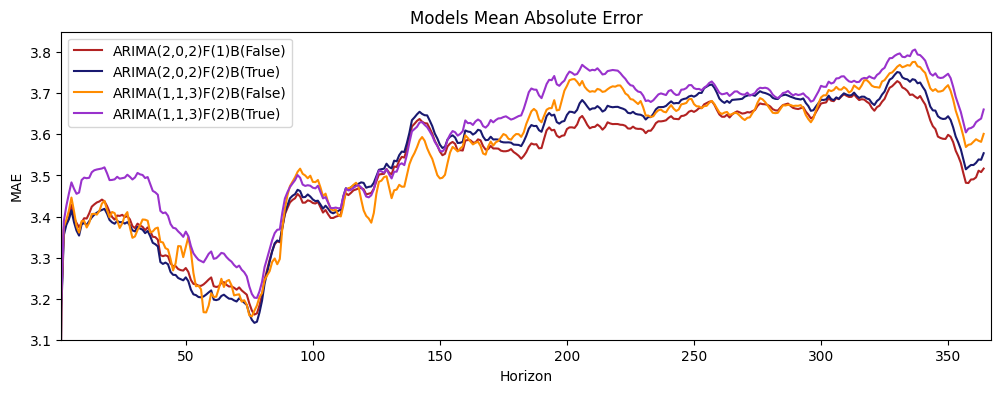

In [17]:
plt.figure(figsize=(12, 4))

sns.lineplot(x=mae_models.index, y=mae_models['ARIMA(2,0,2)F(1)B(False)'], c='firebrick', label='ARIMA(2,0,2)F(1)B(False)')
sns.lineplot(x=mae_models.index, y=mae_models['ARIMA(2,0,2)F(2)B(True)'], c='midnightblue', label='ARIMA(2,0,2)F(2)B(True)')
sns.lineplot(x=mae_models.index, y=mae_models['ARIMA(1,1,3)F(2)B(False)'], c='darkorange', label='ARIMA(1,1,3)F(2)B(False)')
sns.lineplot(x=mae_models.index, y=mae_models['ARIMA(1,1,3)F(2)B(True)'], c='darkorchid', label='ARIMA(1,1,3)F(2)B(True)')

plt.title('Models Mean Absolute Error')
plt.xlabel('Horizon')
plt.ylabel('MAE')

plt.xlim(1, 367)
plt.ylim(3.1, 3.85)

plt.show()

In [18]:
mae_models.head(5)

,"ARIMA(2,0,2)F(1)B(False)","ARIMA(2,0,2)F(2)B(True)","ARIMA(1,1,3)F(2)B(False)","ARIMA(1,1,3)F(2)B(True)"
0,2.281982,2.292559,2.308841,2.319515
1,3.181168,3.169286,3.202562,3.191452
2,3.368581,3.354628,3.374456,3.388485
3,3.384887,3.379723,3.392102,3.425934
4,3.395728,3.393208,3.414538,3.455868


The plot above is cropped because the first MSE value is considerably lower than the others, making it nearly impossible to visualize long-term performance if kept on the same scale.

We can see that there is no single best model across all periods, the best model depends on the specific window selected for analysis. That said, the model that performed best in the long run was the ARIMA(2,0,2) with one Fourier component. Since our main goal is to obtain the most accurate forecasts with the smallest confidence interval, we chose Model ARIMA(2,0,2) with one Fourier component.

## Residual Analysis

In [19]:
df_ml = pd.concat([df_train_valid, fourier(1, 365, df_train_valid.shape[0])], axis=1)

In [20]:
model = ARIMA(df_ml['tavg'], df_ml[["sin_1", "cos_1"]], order=(2,0,2)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   tavg   No. Observations:                 2555
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -6578.051
Date:                Sun, 07 Dec 2025   AIC                          13172.102
Time:                        15:03:09   BIC                          13218.868
Sample:                             0   HQIC                         13189.062
                               - 2555                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        284.8000      0.282   1009.899      0.000     284.247     285.353
sin_1        -12.3950      0.402    -30.844      0.000     -13.183     -11.607
cos_1         -6.4772      0.340    -19.045      0.000      -7.144      -5.811
ar.L1          1.0953      0.117      9.354      0.000       0.866       1.325
ar.L2         -0.2263      0.077     -2.933      0.003      -0.378      -0.075
ma.L1         -0.1920      0.116     -1.655      0.098      -0.419       0.035
ma.L2         -0.2933      0.036     -8.191      0.000      -0.363      -0.223
sigma2        10.0837      0.230     43.876      0.000       9.633      10.534
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               238.16
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.79   Skew:                            -0.38
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The dynamic harmonic regression model with ARIMA(2,0,2) errors provided a good representation of the temperature series, capturing both the strong annual seasonal pattern and the high day-to-day persistence. The Fourier terms (sin and cos) were highly significant, confirming the presence of a well-defined seasonal cycle. The Ljung–Box test indicated no remaining autocorrelation in the residuals (p = 0.95), suggesting that the ARMA structure successfully accounted for short-term dependence. However, the residuals showed clear deviations from normality (Jarque–Bera p < 0.001), with slight left skewness and heavier tails, and the heteroskedasticity test also rejected constant variance (H p < 0.001).

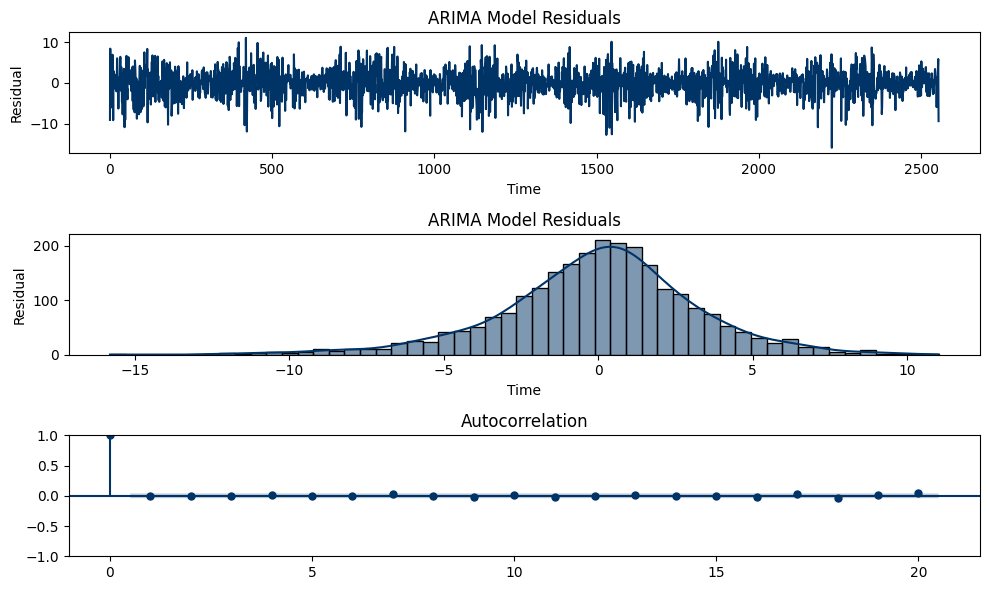

In [21]:
fig, ax = plt.subplots(3, 1, figsize=(10, 6))

sns.lineplot(model.resid, ax=ax[0])
ax[0].set_title('ARIMA Model Residuals')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Residual')

sns.histplot(model.resid, kde=True, ax=ax[1])
ax[1].set_title('ARIMA Model Residuals')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Residual')

sm.graphics.tsa.plot_acf(model.resid, lags=20, ax=ax[2])

plt.tight_layout()
plt.show()

# Model

So far, we have used only classic time series forecasting methods. To further improve our forecasts, we will incorporate machine learning, specifically, a tree-based model.

The initial idea is simple: take the residuals from our dynamic harmonic regression and, using the other available features, try to predict them. However, this approach has a critical flaw: the training and forecasting residuals from our ARIMA model differ substantially, making them unsuitable for training a machine learning model.

To overcome this issue, we will generate residuals using only the harmonic terms. This should be sufficient to remove seasonality. Then, to handle autocorrelation, we will apply differencing. Ideally, this will make the data approximately time-independent, allowing us to use it freely in the machine learning model.


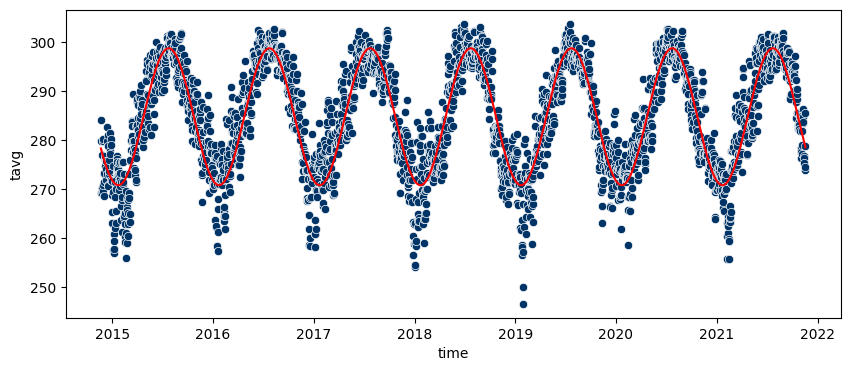

In [22]:
df_ml['seasonal_pattern'] = (-12.3950 * df_ml['sin_1']) + (-6.4772 * df_ml['cos_1']) + 284.8000

plt.figure(figsize=(10, 4))
sns.scatterplot(x='time', y='tavg', data=df_ml)
sns.lineplot(x='time', y='seasonal_pattern', data=df_ml, color='red')
plt.show()

A simple differencing step was not enough to completely remove the remaining time dependence in our data. However, applying a seasonal division plus a constant appears to have correctly removed the autocorrelation, likely because the series exhibited seasonal heteroscedasticity.

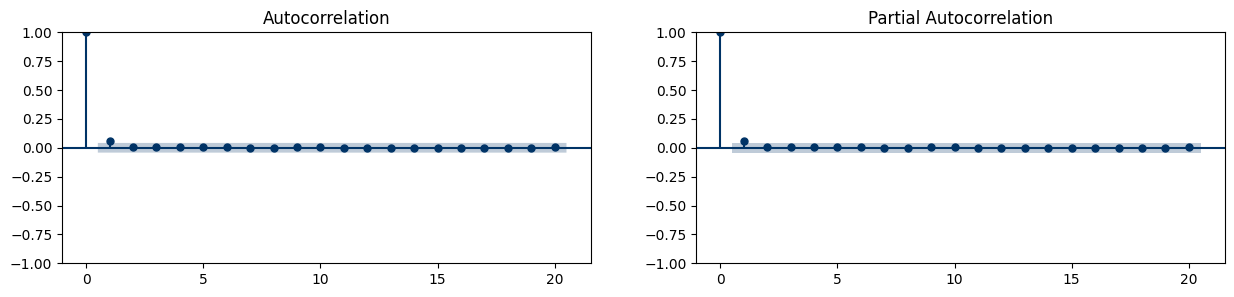

count    2190.000000
mean        1.131451
std         3.581243
min         0.007242
25%         0.864762
50%         1.008074
75%         1.172604
max       167.730452
Name: seasonal_resid, dtype: float64

In [23]:
df_ml['seasonal_resid'] = df_ml['tavg'] - df_ml['seasonal_pattern'] + 24.5
s = (df_ml['seasonal_resid'] / (df_ml['seasonal_resid'].shift(365))).dropna()

fig, ax = plt.subplots(1, 2, figsize=(15, 3))

sm.graphics.tsa.plot_acf(s, lags=20, ax=ax[0])
sm.graphics.tsa.plot_pacf(s, lags=20, ax=ax[1])
plt.show()

s.describe()

In [24]:
df_ml['ml_resid'] = df_ml['seasonal_resid'] / (df_ml['seasonal_resid'].shift(365))
df_ml.to_parquet(os.path.join(DATA_PATH_WRANGLE, 'weather_linear_resid.parquet'))